In [ ]:
pip install bayesian-optimization


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:


# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit


import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from bayes_opt import BayesianOptimization


import time


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

maindf = pd.read_csv(r"/content/XAUUSD_D1.csv", sep="\t", parse_dates=["Time"], dayfirst=True)

maindf['Time'] = pd.to_datetime(maindf['Time'], format='%Y-%m-%d')

maindf = maindf.loc[(maindf['Time'] >= '2006-12-31')
                     & (maindf['Time'] <= '2022-12-01')]

# Separamos los valores de cierre
closedf = maindf[['Time','Close']]
print("Shape de closedf:", closedf.shape)

close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Mounted at /content/drive
Shape de closedf: (4961, 2)
Total data for prediction:  4961


In [ ]:
del closedf['Time']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(4961, 1)


In [ ]:
training_size=int(len(closedf)*0.75)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (3720, 1)
test_data:  (1241, 1)


In [ ]:
# Convierte un array de valores en un matriz dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 3
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (3716, 3)
y_train:  (3716,)
X_test:  (1237, 3)
y_test (1237,)


In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (3716, 3, 1)
X_test:  (1237, 3, 1)


In [ ]:
print(X_train)

[[[0.01970875]
  [0.02033118]
  [0.02271201]
  [0.01415418]
  [0.01071201]]

 [[0.02033118]
  [0.02271201]
  [0.01415418]
  [0.01071201]
  [0.        ]]

 [[0.02271201]
  [0.01415418]
  [0.01071201]
  [0.        ]
  [0.00096959]]

 ...

 [[0.41610992]
  [0.42117697]
  [0.42269913]
  [0.42123859]
  [0.42170627]]

 [[0.42117697]
  [0.42269913]
  [0.42123859]
  [0.42170627]
  [0.42760664]]

 [[0.42269913]
  [0.42123859]
  [0.42170627]
  [0.42760664]
  [0.43126997]]]


In [ ]:
# Función para crear el modelo LSTM con los hiperparámetros especificados
from tensorflow.keras.activations import tanh
from keras.losses import mse
from keras.layers import Reshape
from tensorflow.keras.layers import Bidirectional


def build_model(n_layers, dropout_rate, n_neurons, learning_rate):
    model = Sequential()

    # Agregar capa de convolución 1D previa
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=X_train.shape[1:]))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(Flatten())
    model.add(Reshape((X_train.shape[1]//3, 32)))

    
    for i in range(n_layers):
        if i == 0:
            model.add(Bidirectional(LSTM(n_neurons, activation=tanh, input_shape=X_train.shape[1:], return_sequences=True)))
        else:
            model.add(Bidirectional(LSTM(n_neurons, activation=tanh, return_sequences=True)))
        model.add(Dropout(dropout_rate))
    model.add(LSTM(n_neurons, activation=tanh))
    model.add(Dense(1, activation='linear'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=mse)
    return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Función para entrenar y evaluar el modelo con los hiperparámetros dados y devolver la pérdida
def objective(n_layers, dropout_rate, n_neurons, learning_rate):
    # Convertir los valores de los hiperparámetros en los tipos adecuados
    n_layers = round(n_layers)
    n_neurons = round(n_neurons)
    # Crear el modelo con los hiperparámetros dados
    model = build_model(n_layers, dropout_rate, n_neurons, learning_rate)
    # Entrenar el modelo con los datos de entrenamiento
    early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min')
    model.fit(X_train, y_train, epochs=100, validation_split=0.1, callbacks=[early_stop], verbose=0)
    # Evaluar el modelo en el conjunto de prueba
    loss = -model.evaluate(X_test, y_test, verbose=0)
    return loss

In [ ]:
pip install --upgrade bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Crear el objeto de optimización bayesiana y especificar los límites de los hiperparámetros
optimizer = BayesianOptimization(
    f=objective,
    pbounds={
        'n_layers': (1, 6),
        'dropout_rate': (0.01, 0.99),
        'n_neurons': (32, 200),
        'learning_rate': (1e-10, 1e-2)
    },
    verbose=2,
    random_state=1
)

In [ ]:
optimizer.maximize(n_iter=10)

|   iter    |  target   | dropou... | learni... | n_layers  | n_neurons |
-------------------------------------------------------------------------
| 1         | -0.000286 | 0.1538    | 0.0009234 | 1.931     | 90.05     |
| 2         | -0.001463 | 0.3988    | 0.005388  | 3.096     | 147.1     |
| 3         | -0.000519 | 0.2104    | 0.008781  | 1.137     | 144.6     |
| 4         | -0.00144  | 0.419     | 0.005587  | 1.702     | 65.28     |
| 5         | -0.001924 | 0.7947    | 0.009683  | 2.567     | 148.3     |
| 6         | -0.01267  | 0.8689    | 0.008946  | 1.425     | 38.56     |
| 7         | -0.000193 | 0.1764    | 0.008781  | 1.492     | 102.7     |
| 8         | -0.1309   | 0.9487    | 0.005332  | 4.459     | 85.01     |
| 9         | -0.00167  | 0.6828    | 0.008346  | 1.091     | 158.0     |
| 10        | -0.000241 | 0.01      | 0.001071  | 1.0       | 95.06     |
| 11        | -0.000616 | 0.1244    | 0.0006137 | 5.969     | 99.13     |
| 12        | -0.005176 | 0.7372    | 

In [ ]:
best_params = optimizer.max["params"]
best_score = optimizer.max["target"]
print(best_params)
print(best_score)

{'dropout_rate': 0.01, 'learning_rate': 0.01, 'n_layers': 1.0, 'n_neurons': 110.9685226720024}
-0.00012591778067871928


In [ ]:
print(round(best_params['n_layers']))
print(best_params['dropout_rate'])
print(round(best_params['n_neurons']))
print(best_params['learning_rate'])

1
0.01
111
0.01


In [ ]:
best_model_bayes = build_model(round(best_params['n_layers']), best_params['dropout_rate'], round(best_params['n_neurons']), best_params['learning_rate'])


In [ ]:
best_model_bayes.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 1, 32)             128       
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 1, 32)            0         
 g1D)                                                            
                                                                 
 flatten_20 (Flatten)        (None, 32)                0         
                                                                 
 reshape_20 (Reshape)        (None, 1, 32)             0         
                                                                 
 bidirectional_59 (Bidirecti  (None, 1, 222)           127872    
 onal)                                                           
                                                                 
 dropout_59 (Dropout)        (None, 1, 222)          

In [ ]:
def train_model(model, X_train, y_train, X_test, y_test, epochs, batch_size):
    optimizer = Adam(learning_rate=best_params['learning_rate'])
    model.compile(optimizer=optimizer, loss=mse)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1)
    return history



In [ ]:
history = train_model(best_model_bayes, X_train, y_train, X_test, y_test, 100, 32)

Epoch 1/100
117/117 [==============================] - 12s 37ms/step - loss: 0.0075 - val_loss: 2.6877e-04
Epoch 2/100
117/117 [==============================] - 2s 21ms/step - loss: 1.5859e-04 - val_loss: 4.1547e-04
Epoch 3/100
117/117 [==============================] - 2s 15ms/step - loss: 1.5641e-04 - val_loss: 1.8218e-04
Epoch 4/100
117/117 [==============================] - 2s 15ms/step - loss: 1.6980e-04 - val_loss: 7.9865e-04
Epoch 5/100
117/117 [==============================] - 2s 15ms/step - loss: 1.5901e-04 - val_loss: 3.0988e-04
Epoch 6/100
117/117 [==============================] - 2s 15ms/step - loss: 2.1884e-04 - val_loss: 1.8653e-04
Epoch 7/100
117/117 [==============================] - 2s 15ms/step - loss: 3.1184e-04 - val_loss: 3.1434e-04
Epoch 8/100
117/117 [==============================] - 2s 21ms/step - loss: 2.4459e-04 - val_loss: 0.0013
Epoch 9/100
117/117 [==============================] - 3s 24ms/step - loss: 1.4281e-04 - val_loss: 1.7462e-04
Epoch 10/100
117/

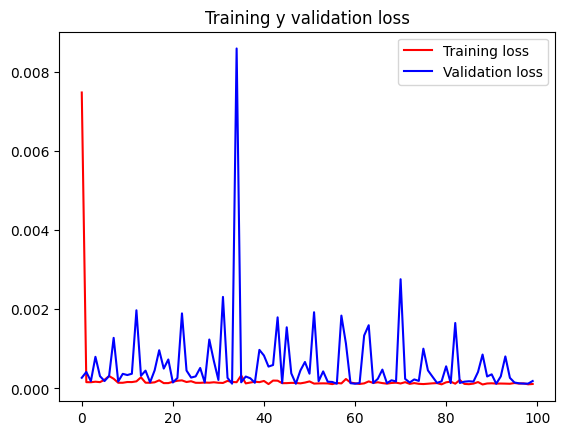

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training y validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=best_model_bayes.predict(X_train)
test_predict=best_model_bayes.predict(X_test)
train_predict.shape, test_predict.shape


39/39 [==============================] - 0s 4ms/step


((3716, 1), (1237, 1))

In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [ ]:
# Evaluation metrices RMSE, MAE and MAPE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MAPE: ", mape(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MAPE: ", mape(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  13.369925249363574
Train data MAPE:  0.8269068626186972
Train data MAE:  9.483154787915646
-------------------------------------------------------------------------------------
Test data RMSE:  19.987007539244686
Test data MAPE:  0.865278118822833
Test data MAE:  15.075348686495802


In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Precio original','Precio predicho Train','Precio predicho Test'])


plotdf = pd.DataFrame({'date': close_stock['Time'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Precio (USD)','date': 'Fecha'})
fig.update_layout(title_text='Comparación entre precio original de cierre y precio predicho de cierre',
                  plot_bgcolor='white', font_size=14, font_color='black', legend_title_text='Precio cierre')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (4961, 1)
Test predicted data:  (4961, 1)
